In [1]:
# importing libs
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout
from keras.models import Model
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K

In [2]:
# for reproducing reslut
from numpy.random import seed
seed(1)
import tensorflow 
tensorflow.random.set_seed(3)
# defining parameters
# define (n,k) here for (n,k) autoencoder
# n = n_channel 
# k = log2(M)  ==> so for (7,4) autoencoder n_channel = 7 and M = 2^4 = 16 
M = 4
k = np.log2(M)
k = int(k)
n_channel = 2
R = k/n_channel
print ('M:',M,'k:',k,'n:',n_channel)

M: 4 k: 2 n: 2


In [3]:
#generating data of size N
N = 8000
label = np.random.randint(M,size=N)
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)
# checking data shape
data = np.array(data)
print (data.shape)

(8000, 4)


In [4]:
# defining autoencoder and it's layer
input_signal = Input(shape=(M,))
encoded = Dense(128, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
encoded2 = Lambda(lambda x: np.sqrt(n_channel)*K.l2_normalize(x,axis=1))(encoded1)

EbNo_train = 5.01187 #  coverted 7 db of EbNo
encoded3 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.01)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

C:\Users\Surya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
# saving keras model
from keras.models import load_model

In [6]:
# making encoder from full autoencoder
encoder = Model(input_signal, encoded2)
# making decoder from full autoencoder
encoded_input = Input(shape=(n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

In [7]:
# generating data for checking BER
# if you're not using t-sne for visulation than set N to 70,000 for better result 
# for t-sne use less N like N = 1500
N = 50000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)
# checking generated data
temp_test = 6
print (test_data[temp_test][test_label[temp_test]],test_label[temp_test])

1.0 1


In [8]:
# for plotting learned consteallation diagram
scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)

1/1 [==============================] - 0s 35ms/step
(4, 1, 2)


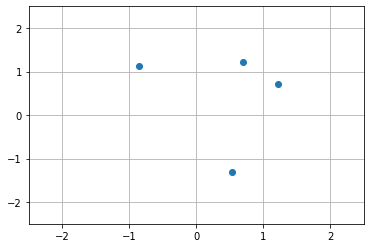

In [9]:
# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.show()
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

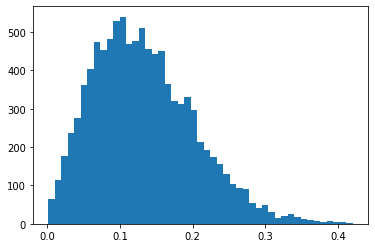

In [10]:
# calculating BER
from scipy.stats import rice

# Define the Rice distribution parameters
K = 0.5 # scale parameter
sigma = 0.1 # shape parameter

# Generate Rician noise samples
n = rice.rvs(K, scale=sigma, size=10000)

# Plot the Ricean noise
import matplotlib.pyplot as plt
plt.hist(n, bins='auto')
plt.show()

In [13]:
# this is optimized BER function so it can handle large number of N
# previous code has another for loop which was making it slow
EbNodB_range = list(frange(-4,8.5,0.5))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
                                 
    # Generate Rician noise samples
    noise = rice.rvs(K, scale=sigma+n, size=(N, 2))
    
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])

1563/1563 [==============================] - 3s 2ms/step
SNR: -4 BER: 0.74742
1563/1563 [==============================] - 4s 2ms/step
SNR: -3.5 BER: 0.71284
1563/1563 [==============================] - 3s 2ms/step
SNR: -3.0 BER: 0.7131
1563/1563 [==============================] - 3s 2ms/step
SNR: -2.5 BER: 0.71776
1563/1563 [==============================] - 4s 2ms/step
SNR: -2.0 BER: 0.7245
1563/1563 [==============================] - 2s 2ms/step
SNR: -1.5 BER: 0.728
1563/1563 [==============================] - 4s 3ms/step
SNR: -1.0 BER: 0.73098
1563/1563 [==============================] - 4s 3ms/step
SNR: -0.5 BER: 0.73544
1563/1563 [==============================] - 3s 2ms/step
SNR: 0.0 BER: 0.73542
1563/1563 [==============================] - 6s 4ms/step
SNR: 0.5 BER: 0.73798
1563/1563 [==============================] - 5s 3ms/step
SNR: 1.0 BER: 0.73892
1563/1563 [==============================] - 4s 3ms/step
SNR: 1.5 BER: 0.7392
1563/1563 [==============================] - 4s 2ms

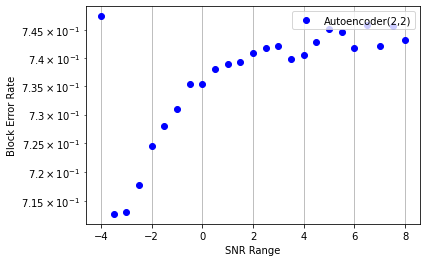

In [14]:
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(2,2)')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)
# for saving figure remove below comment
plt.savefig('AutoEncoder_2_2_constrained_BER_matplotlib')
plt.show()